## Loading

In [17]:
import cv2
import numpy as np
import pandas as pd
from moviepy.editor import VideoFileClip
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Dense, Flatten, Reshape, Input, MaxPooling2D, Dropout, UpSampling2D
from tensorflow.keras.models import Model
from sklearn.decomposition import PCA

## Main

In [18]:
# Helper function to extract frames from video
def extract_frames(video_path, frame_rate=1):
    clip = VideoFileClip(video_path)
    fps = clip.fps
    frame_list = []
    timestamps = []

    for i, frame in enumerate(clip.iter_frames()):
        if i % int(fps / frame_rate) == 0:
            frame_list.append(frame)
            timestamps.append(i / fps)

    return frame_list, timestamps

In [19]:
def process_frames_to_dataframe(frames, timestamps):
    def build_autoencoder(input_shape=(224, 224, 3)):
        input_layer = Input(shape=input_shape)

        # Encoder
        x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_layer)
        x = MaxPooling2D((2, 2))(x) 
        x = Dropout(0.25)(x) 
        x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
        x = MaxPooling2D((2, 2))(x) 
        x = Dropout(0.25)(x) 
        x = Flatten()(x)
        latent_space = Dense(16, activation='relu', name='latent_features')(x)

        # Decoder
        x = Dense(56 * 56 * 16, activation='relu')(latent_space)
        x = Reshape((56, 56, 16))(x)
        x = Conv2DTranspose(16, (3, 3), activation='relu', padding='same')(x)
        x = UpSampling2D((2, 2))(x) 
        x = Dropout(0.25)(x) 
        x = Conv2DTranspose(32, (3, 3), activation='relu', padding='same')(x)
        x = UpSampling2D((2, 2))(x) 
        decoded_output = Conv2DTranspose(3, (3, 3), activation='sigmoid', padding='same')(x)

        # Models
        autoencoder = Model(inputs=input_layer, outputs=decoded_output)
        encoder = Model(inputs=input_layer, outputs=latent_space)

        autoencoder.compile(optimizer='adam', loss='mse')
        return autoencoder, encoder


    def manual_kmeans(data, n_clusters, max_iter=10, tol=1e-4):
        # Randomly initialize centroids using a small sample of the data
        np.random.seed(0)
        centroids = data[np.random.choice(data.shape[0], n_clusters, replace=False)]

        for iteration in range(max_iter):
            # Compute distances and assign clusters (vectorized)
            distances = np.linalg.norm(data[:, None, :] - centroids[None, :, :], axis=2)
            labels = np.argmin(distances, axis=1)

            # Compute new centroids
            new_centroids = np.array([
                data[labels == cluster].mean(axis=0) if (labels == cluster).any() else centroids[cluster]
                for cluster in range(n_clusters)
            ])

            # Check for convergence
            if np.all(np.linalg.norm(new_centroids - centroids, axis=1) < tol):
                break

            centroids = new_centroids

        return centroids, labels

    print("Resizing frames...")
    resized_frames = np.array([cv2.resize(frame, (224, 224)) for frame in frames])
    resized_frames = resized_frames / 255.0

    autoencoder, encoder = build_autoencoder()
    autoencoder.summary()

    frames = np.array(resized_frames)

    print("Training the autoencoder...")
    autoencoder.fit(frames, frames, epochs=100, batch_size=32, verbose=1)

    print("Extracting latent features...")
    latent_features = encoder.predict(frames)

    print("Calculating brightness...")
    brightness = np.array([
        frame.sum() / (frame.shape[0] * frame.shape[1] * frame.shape[2]) for frame in frames
    ])

    print("Clustering for dominant colors...")
    reshaped_frames = frames.reshape(-1, 3)  # Flatten frames to pixel-level colors

    # Sample a subset of pixels for clustering
    sample_indices = np.random.choice(reshaped_frames.shape[0], size=10000, replace=False)
    sampled_pixels = reshaped_frames[sample_indices]

    # Perform manual K-Means clustering on the sampled pixels
    dominant_colors, _ = manual_kmeans(sampled_pixels, n_clusters=3)

    # Map dominant colors back to frames
    color_features = []
    for frame_pixels in tqdm(frames, desc="Mapping dominant colors to frames"):
        frame_pixels = frame_pixels.reshape(-1, 3)
        distances = np.linalg.norm(frame_pixels[:, None, :] - dominant_colors[None, :, :], axis=2)
        labels = np.argmin(distances, axis=1)

        # Calculate average colors for the frame
        color_sums = np.zeros((3, 3))
        count = np.zeros(3)
        for label, pixel in zip(labels, frame_pixels):
            color_sums[label] += pixel
            count[label] += 1

        avg_colors = np.divide(color_sums, count[:, None], where=(count[:, None] != 0))
        color_features.append(avg_colors.mean(axis=0))  # Combine per-cluster colors

    print("Reducing dimensions of latent features...")
    pca = PCA(n_components=2)
    reduced_features = pca.fit_transform(latent_features)

    print("Combining features into a DataFrame...")
    data = {
        "timestamp": timestamps,
        "brightness": brightness,
        "color1": [c[0] for c in color_features],
        "color2": [c[1] for c in color_features],
        "color3": [c[2] for c in color_features],
        "feature1": reduced_features[:, 0],
        "feature2": reduced_features[:, 1],
    }
    feature_df = pd.DataFrame(data)

    return feature_df


In [20]:
# Main function to process video and return a DataFrame
def analyze_video(video_path):
    print("Extracting frames from video...")
    frames, timestamps = extract_frames(video_path, frame_rate=0.05)

    print("Analyzing frames...")
    df = process_frames_to_dataframe(frames, timestamps)

    return df

## Run

In [21]:
# Upload and analyze your .mp4 video file
video_path = "Test.mp4"
df_results = analyze_video(video_path)

# Display the DataFrame
print(df_results)

Extracting frames from video...
Analyzing frames...
Resizing frames...


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 112, 112, 16)   │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 56, 56, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 56, 56, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent_features (Dense)         │ (None, 16)             │       802,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 50176)          │       852,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 56, 56, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_5              │ (None, 56, 56, 16)     │         2,320 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_6              │ (None, 112, 112, 32)   │         4,640 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_7              │ (None, 224, 224, 3)    │           867 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,669,171 (6.37 MB)

 Trainable params: 1,669,171 (6.37 MB)

 Non-trainable params: 0 (0.00 B)

Training the autoencoder...
Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 284ms/step - loss: 0.1022
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 283ms/step - loss: 0.0995
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 275ms/step - loss: 0.0971
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 258ms/step - loss: 0.0877
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 232ms/step - loss: 0.0811
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 233ms/step - loss: 0.0810
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 230ms/step - loss: 0.0775
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 261ms/step - loss: 0.0716
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 234ms/step - loss: 0.0723
Epoch 10/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 230ms/step - loss: 0.0660
Epoch 11/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 258ms/step - loss: 0.0655
Epoch 12/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 284ms/step - loss: 0.0627
Epoch 13/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 247ms/step - loss: 0.0593
Epoch 14/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 265ms/step - loss: 0.0588
Epoch 15/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 26

Mapping dominant colors to frames: 100%|██████████| 55/55 [00:05<00:00, 10.35it/s]

Reducing dimensions of latent features...
Combining features into a DataFrame...
    timestamp  brightness    color1    color2    color3   feature1   feature2
0         0.0    0.255209  0.195207  0.155462  0.111443 -10.612523  -6.537467
1        20.0    0.234057  0.452860  0.341055  0.280436  11.070269 -12.928053
2        40.0    0.211482  0.436164  0.346580  0.273760  13.052156 -10.275180
3        60.0    0.309238  0.425329  0.384360  0.385126  -8.370898   2.928304
4        80.0    0.247844  0.445163  0.357292  0.292092  12.049587  -7.169034
5       100.0    0.624865  0.412478  0.443676  0.435968 -22.682930  -0.676200
6       120.0    0.211128  0.457198  0.352920  0.276149  -2.065510  -8.424603
7       140.0    0.443491  0.376382  0.410130  0.444078 -21.367735   0.479971
8       160.0    0.288848  0.448122  0.407436  0.295906 -13.805800  -0.661225
9       180.0    0.242114  0.450764  0.360349  0.276906   0.766551  -5.689367
10      200.0    0.179619  0.441694  0.349620  0.288843   2.6

      color1    color2    color3
0   0.195207  0.155462  0.111443
1   0.452860  0.341055  0.280436
2   0.436164  0.346580  0.273760
3   0.425329  0.384360  0.385126
4   0.445163  0.357292  0.292092
5   0.412478  0.443676  0.435968
6   0.457198  0.352920  0.276149
7   0.376382  0.410130  0.444078
8   0.448122  0.407436  0.295906
9   0.450764  0.360349  0.276906
10  0.441694  0.349620  0.288843
11  0.410888  0.435610  0.432267
12  0.439691  0.341330  0.277700
13  0.429993  0.469125  0.375279
14  0.441105  0.351945  0.281383
15  0.434597  0.400417  0.425381
16  0.436397  0.361770  0.356547
17  0.476520  0.398379  0.349343
18  0.420999  0.336819  0.279897
19  0.472035  0.387886  0.326069
20  0.417572  0.403323  0.363010
21  0.452102  0.466045  0.454503
22  0.441491  0.348682  0.282623
23  0.443858  0.376895  0.338413
24  0.395518  0.403503  0.303008
25  0.416079  0.348377  0.308102
26  0.445590  0.377876  0.320281
27  0.436958  0.399566  0.327290
28  0.458524  0.336121  0.280057
29  0.4714

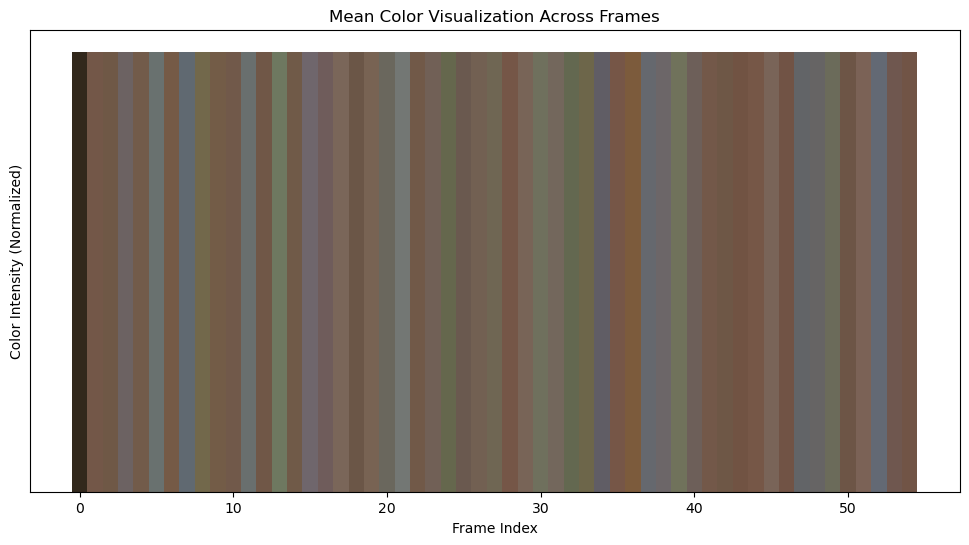

In [22]:
import matplotlib.pyplot as plt
import numpy as np

def plot_mean_colors(feature_df):
    # Extract mean colors
    mean_colors = feature_df[["color1", "color2", "color3"]]

    # Create a figure
    plt.figure(figsize=(12, 6))

    print(mean_colors)
    # Loop through each frame's color and plot
    for i, color in enumerate(mean_colors.values):
        # Ensure the color is a tuple of 3 values
        color = np.clip(color, 0, 1)
        color = tuple(color)  # Convert to tuple for safety
        plt.bar(i, 1, color=color, width=1.0, edgecolor='none')  # Use color as RGB

    # Add plot details
    plt.title("Mean Color Visualization Across Frames")
    plt.xlabel("Frame Index")
    plt.ylabel("Color Intensity (Normalized)")
    plt.yticks([])  # Remove y-axis ticks for better clarity
    plt.show()

# Example usage
# Assuming `feature_df` is your dataframe with the given structure
plot_mean_colors(df_results)


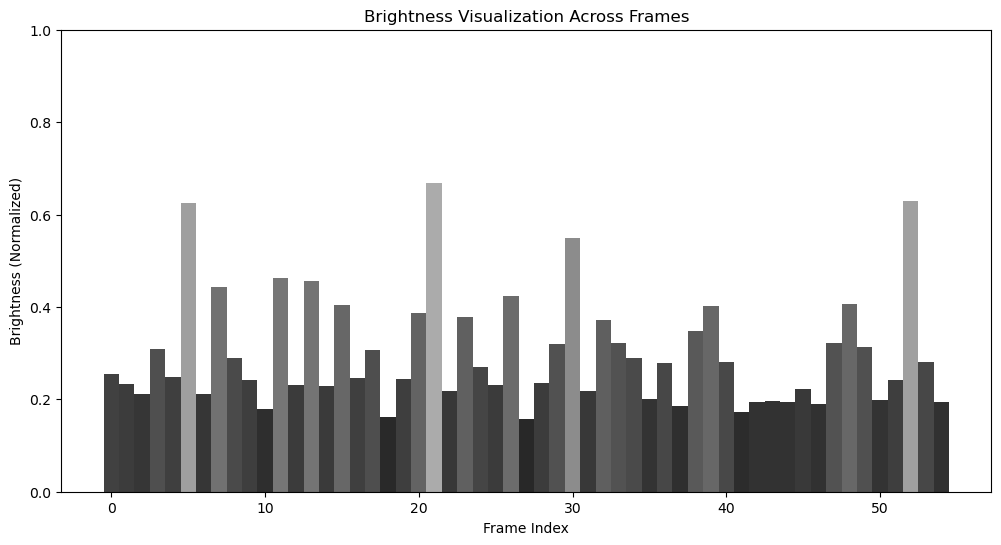

In [23]:
import matplotlib.pyplot as plt
import numpy as np

def plot_brightness(feature_df):
    # Extract brightness values
    brightness = feature_df["brightness"].values

    # Create a figure
    plt.figure(figsize=(12, 6))

    # Normalize brightness for color mapping (grayscale between 0 and 1)
    brightness_normalized = np.clip(brightness, 0, 1)

    # Loop through each frame's brightness and plot
    for i, value in enumerate(brightness_normalized):
        # Use grayscale for color (same intensity for R, G, B)
        gray_color = (value, value, value)
        plt.bar(i, value, color=gray_color, width=1.0, edgecolor='none')

    # Add plot details
    plt.title("Brightness Visualization Across Frames")
    plt.xlabel("Frame Index")
    plt.ylabel("Brightness (Normalized)")
    plt.ylim(0, 1)  # Brightness is normalized between 0 and 1
    plt.show()

# Example usage
# Assuming `feature_df` is your dataframe with the given structure
plot_brightness(df_results)

In [24]:
from sklearn.preprocessing import StandardScaler

# List of features to scale
features_to_scale = ['brightness', 'color1', 'color2', 'color3', 'feature1', 'feature2']

# Standardize the features
scaler = StandardScaler()
df_results[features_to_scale] = scaler.fit_transform(df_results[features_to_scale])

In [25]:
from sklearn.preprocessing import PolynomialFeatures

# Create interaction terms
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
interaction_features = poly.fit_transform(df_results[features_to_scale])

# Convert to DataFrame
interaction_df = pd.DataFrame(interaction_features, columns=poly.get_feature_names_out(features_to_scale))

# Add to original DataFrame
df_results = pd.concat([df_results, interaction_df], axis=1)

In [26]:
print(df_results.corr())

                     timestamp  brightness    color1    color2    color3  \
timestamp             1.000000   -0.087882  0.154196  0.052320  0.087937   
brightness           -0.087882    1.000000 -0.166679  0.623421  0.669337   
color1                0.154196   -0.166679  1.000000  0.363246  0.074756   
color2                0.052320    0.623421  0.363246  1.000000  0.808435   
color3                0.087937    0.669337  0.074756  0.808435  1.000000   
feature1              0.224552   -0.731660  0.194047 -0.448572 -0.385377   
feature2              0.137025    0.351539 -0.174359  0.322334  0.564372   
brightness           -0.087882    1.000000 -0.166679  0.623421  0.669337   
color1                0.154196   -0.166679  1.000000  0.363246  0.074756   
color2                0.052320    0.623421  0.363246  1.000000  0.808435   
color3                0.087937    0.669337  0.074756  0.808435  1.000000   
feature1              0.224552   -0.731660  0.194047 -0.448572 -0.385377   
feature2    

In [27]:
df_results.to_csv('C:/Users/nosso/OneDrive/Desktop/CNN.csv')